In [59]:
import numpy as np
import pagn.constants as ct
import matplotlib.pyplot as plt
import pagn

import NT_disk_Eqns_V1 as jscript

from os import makedirs

#some nicer code based on Test_zone.ipynb

In [98]:
def NTvsSG_disc_solver(MBH_power, spin, alpha, mdot, eps=0.1, le=None, steps=int(1e4), print=True, plot=True):
    #general scaling from Abramowicz and Fragile
    MBH=10**MBH_power * ct.MSun #in kgs
    M=MBH * ct.G /(ct.c*ct.c)
    R_G=M

    m=MBH/ct.MSun
    Rsch= 2*ct.G*MBH/ct.c**2

    if mdot==None and le==None:
        raise ValueError('Please provide an accretion rate or Eddington ratio!')
    elif le==None:
        le=mdot*eps
    elif mdot==None:
        mdot=le/eps

    disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le=le, eps=eps)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

    Rmin= jscript.R_isco_function(MBH, spin) #uses relativistic eqn for ISCO to set inner edge of disc
    r_isco=jscript.R_isco_function(MBH, spin)

    R=np.logspace(np.log10(r_isco), np.log10(Rmax), steps+1)
    # R=np.linspace(r_isco, Rmax, steps+1)

    R_im=jscript.R_inner_mid(r_isco, MBH, mdot, alpha)
    R_mo=jscript.R_mid_outer(r_isco, mdot)
    R_oa=jscript.R_outer_AGN(r_isco, MBH, mdot, alpha)

    R_agn=disk.R_AGN/R_G

    if print==True:
        print(R_oa)

    Rs=[]
    sigmas=[]
    Hs=[]
    hrs=[]
    rho0s=[]
    rhos=[]
    Ts=[]

    betas=[]
    taus=[]

    flag=0
    flag2=0
    flag3=0

    r_tr=0
    r_rel=0
    r_outer=0

    inner_flag=0
    mid_flag=0
    outer_flag=0

    for i in range(100, steps+1):
        r=R[i]
        y=np.sqrt(r/M)
        rstar=(r/M)

        if rstar<R_im:
            if inner_flag==0:
                if print==True:
                    print(f'disk in inner region')
                inner_flag=1
            rho_0=jscript.rho_0_NT(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT(r, MBH, spin, mdot, alpha)
            # H=jscript.H_NT(r, MBH, spin, mdot)
            H=jscript.H_NT_2(r, MBH, spin, mdot)
            sigma=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)
        
        if R_im<=rstar<R_mo:
            if mid_flag==0:
                if print==True:
                    print(f'disk transitions to middle region at {rstar} Rg')
                mid_flag=1
            rho_0=jscript.rho_0_NT_Middle(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_Middle(r, MBH, spin, mdot, alpha)
            sigma=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)
        
        if R_mo<rstar:
            if outer_flag==0:
                if print==True:
                    print(f'disk transitions to outer region at {rstar} Rg')
                outer_flag=1
            rho_0=jscript.rho_0_NT_Outer(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT_Outer(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_Outer(r, MBH, spin, mdot, alpha)
            sigma=jscript.Sigma_NT_Outer(r, MBH, spin, mdot, alpha)
        
        sigmas.append(sigma)
        Ts.append(T)
        Hs.append(H)
        rho0s.append(rho_0)
        Rs.append(rstar)

        hr=H/(r*R_G)

        hrs.append(hr)

        rho=sigma/(2*H)
        rhos.append(rho)

        omega=np.sqrt(ct.G * MBH / (r*r*r))

        v=omega * r
        vc=v/ct.c

        Qt= omega*omega / (2 * np.pi * ct.G * rho)

        if vc<0.1 and flag==0:
            if print==True:
                print(f'disk stops being relativistic at {r/R_G} Rg')
            r_rel=r
            flag+=1
        
        if r>=disk.R_AGN and flag3==0:
            if print==True:
                print(f'disk begins star formation at {r/R_G} Rg')
            r_outer=r
            flag3+=1
    if plot==True:
        mypath=f'EMRIs_Jupiter_2/NT_vs_SG_profiles/logMBH{MBH_power}/alpha{alpha}/mdot{mdot}/spin{spin}/'

        try:
            makedirs(mypath)
        except FileExistsError:
            pass

        fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=100)

        colour='plasma'
        cmap = plt.colormaps[colour]

        plt.suptitle(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha},'r'$\chi$ = 'f'{spin}')

        i=0

        axs[i].plot(disk.R/M, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
        axs[i].plot(Rs, sigmas, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

        i=1

        axs[i].plot(disk.R/M, disk.T, color=cmap(0.0), label = r"SG")
        axs[i].plot(Rs, Ts, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$T [K] $')

        i=2

        axs[i].plot(disk.R/M, disk.rho*ct.SI_to_gcm3, color=cmap(0.0), label = r"SG")
        axs[i].plot(Rs, rho0s, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$\rho [gcm^{-3}] $')

        i=3

        axs[i].plot(disk.R/M, disk.h*ct.SI_to_cms, '-', color=cmap(0.0), label = r"SG")
        axs[i].plot(Rs, Hs, '-', color=cmap(0.8), label = r"NT")

        axs[i].set_ylabel(r'$H [?]$')
        axs[i].legend()

        for i in range(0, 4):
            axs[i].axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
            axs[i].axvline(x=r_rel/M, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
            axs[i].axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
            axs[i].axvline(x=disk.R_AGN/M, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

            axs[i].set_xscale('log')
            axs[i].set_yscale('log')

            axs[i].set_xlabel("r/M")

        plt.tight_layout()
        plt.savefig(f'{mypath}all_profiles.pdf')
        plt.show()

In [99]:
MBH_powers= 4, 5, 6, 7, 8

spins=0.9, 0.99
alphas=0.1, 0.01

mdot = 0.1 #in terms of Ledd
eps = 0.1
le = mdot*eps
# mdot=le/eps

# X=0.7
# b=0
# Opacity='combined'
# kappa=0.2 * (1+X) * 0.1

steps=int(1e4)

for MBH_power in MBH_powers:
    for alpha in alphas:
        for spin in spins:
            NTvsSG_disc_solver(MBH_power, spin, alpha, mdot, eps=0.1, le=None, steps=int(1e4), print=True, plot=True)

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.010000000000000002
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9911 (R=8.81e+06 Rs)
Beginning star formation at index 9911
Mdisk = 68.494617692542 Msun
Mdisk/Mbh = 0.0068494617692542


TypeError: 'bool' object is not callable

In [ ]:
#general scaling from Abramowicz and Fragile
MBH=10**MBH_power * ct.MSun #in kgs
M=MBH * ct.G /(ct.c*ct.c)
R_G=M

m=MBH/ct.MSun
Rsch= 2*ct.G*MBH/ct.c**2

if mdot==None and le==None:
    raise ValueError('Please provide an accretion rate or Eddington ratio!')
elif le==None:
    le=mdot*eps
    disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le=le, eps=eps)
elif mdot==None:
    mdot=le/eps

Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

Rmin= jscript.R_isco_function(MBH, spin) #uses relativistic eqn for ISCO to set inner edge of disc

r_isco=jscript.R_isco_function(MBH, spin)

R=np.logspace(np.log10(r_isco), np.log10(Rmax), steps+1)
# R=np.linspace(r_isco, Rmax, steps+1)

R_im=jscript.R_inner_mid(r_isco, MBH, mdot, alpha)
R_mo=jscript.R_mid_outer(r_isco, mdot)
R_oa=jscript.R_outer_AGN(r_isco, MBH, mdot, alpha)

R_agn=disk.R_AGN / R_G

print(R_oa/R_agn)

mypath=f'EMRIs_Jupiter_2/NT_vs_SG_profiles/logMBH{MBH_power}/alpha{alpha}/mdot{mdot}/spin{spin}/'

try:
    makedirs(mypath)
except FileExistsError:
    pass

Rs=[]
sigmas=[]
Hs=[]
hrs=[]
rho0s=[]
rhos=[]
Ts=[]

betas=[]
taus=[]

flag=0
flag2=0
flag3=0

r_tr=0
r_rel=0
r_outer=0

inner_flag=0
mid_flag=0
outer_flag=0

for i in range(100, steps+1):
    r=R[i]
    y=np.sqrt(r/M)
    rstar=(r/M)

    if rstar<R_im:
        if inner_flag==0:
            print(f'disk in inner region')
            inner_flag=1
        rho_0=jscript.rho_0_NT(r, MBH, spin, mdot, alpha)
        T=jscript.T_NT(r, MBH, spin, mdot, alpha)
        # H=jscript.H_NT(r, MBH, spin, mdot)
        H=jscript.H_NT_2(r, MBH, spin, mdot)
        sigma=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)
    
    if R_im<=rstar<R_mo:
        if mid_flag==0:
            print(f'disk transitions to middle region at {rstar} Rg')
            mid_flag=1
        rho_0=jscript.rho_0_NT_Middle(r, MBH, spin, mdot, alpha)
        T=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)
        H=jscript.H_NT_Middle(r, MBH, spin, mdot, alpha)
        sigma=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)
    
    if R_mo<rstar:
        if outer_flag==0:
            print(f'disk transitions to outer region at {rstar} Rg')
            outer_flag=1
        rho_0=jscript.rho_0_NT_Outer(r, MBH, spin, mdot, alpha)
        T=jscript.T_NT_Outer(r, MBH, spin, mdot, alpha)
        H=jscript.H_NT_Outer(r, MBH, spin, mdot, alpha)
        sigma=jscript.Sigma_NT_Outer(r, MBH, spin, mdot, alpha)
    
    sigmas.append(sigma)
    Ts.append(T)
    Hs.append(H)
    rho0s.append(rho_0)
    Rs.append(rstar)

    hr=H/(r*R_G)

    hrs.append(hr)

    rho=sigma/(2*H)
    rhos.append(rho)

    omega=np.sqrt(ct.G * MBH / (r*r*r))

    v=omega * r
    vc=v/ct.c

    Qt= omega*omega / (2 * np.pi * ct.G * rho)

    if vc<0.1 and flag==0:
        print(f'disk stops being relativistic at {r/R_G} Rg')
        r_rel=r
        flag+=1
    
    if r>=disk.R_AGN and flag3==0:
        print(f'disk begins star formation at {r/R_G} Rg')
        r_outer=r
        flag3+=1

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=100)

colour='plasma'
cmap = plt.colormaps[colour]

plt.suptitle(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha},'r'$\chi$ = 'f'{spin}')

i=0

axs[i].plot(disk.R/M, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
axs[i].plot(Rs, sigmas, '-', color=cmap(0.8), label = r"NT")

axs[i].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

i=1

axs[i].plot(disk.R/M, disk.T, color=cmap(0.0), label = r"SG")
axs[i].plot(Rs, Ts, '-', color=cmap(0.8), label = r"NT")

axs[i].set_ylabel(r'$T [K] $')

i=2

axs[i].plot(disk.R/M, disk.rho*ct.SI_to_gcm3, color=cmap(0.0), label = r"SG")
axs[i].plot(Rs, rho0s, '-', color=cmap(0.8), label = r"NT")

axs[i].set_ylabel(r'$\rho [gcm^{-3}] $')

i=3

axs[i].plot(disk.R/M, disk.h*ct.SI_to_cms, '-', color=cmap(0.0), label = r"SG")
axs[i].plot(Rs, Hs, '-', color=cmap(0.8), label = r"NT")

axs[i].set_ylabel(r'$H [?]$')
axs[i].legend()

for i in range(0, 4):
    axs[i].axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
    axs[i].axvline(x=r_rel/M, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
    axs[i].axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
    axs[i].axvline(x=disk.R_AGN/M, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

    axs[i].set_xscale('log')
    axs[i].set_yscale('log')

    axs[i].set_xlabel("r/M")

plt.tight_layout()
plt.savefig(f'{mypath}all_profiles.pdf')
plt.show()

disk in inner region
disk transitions to middle region at 26.00014416611097 Rg
disk stops being relativistic at 100.0740677205103 Rg
disk transitions to outer region at 212.99277546005044 Rg
disk begins star formation at 17629521.279353853 Rg


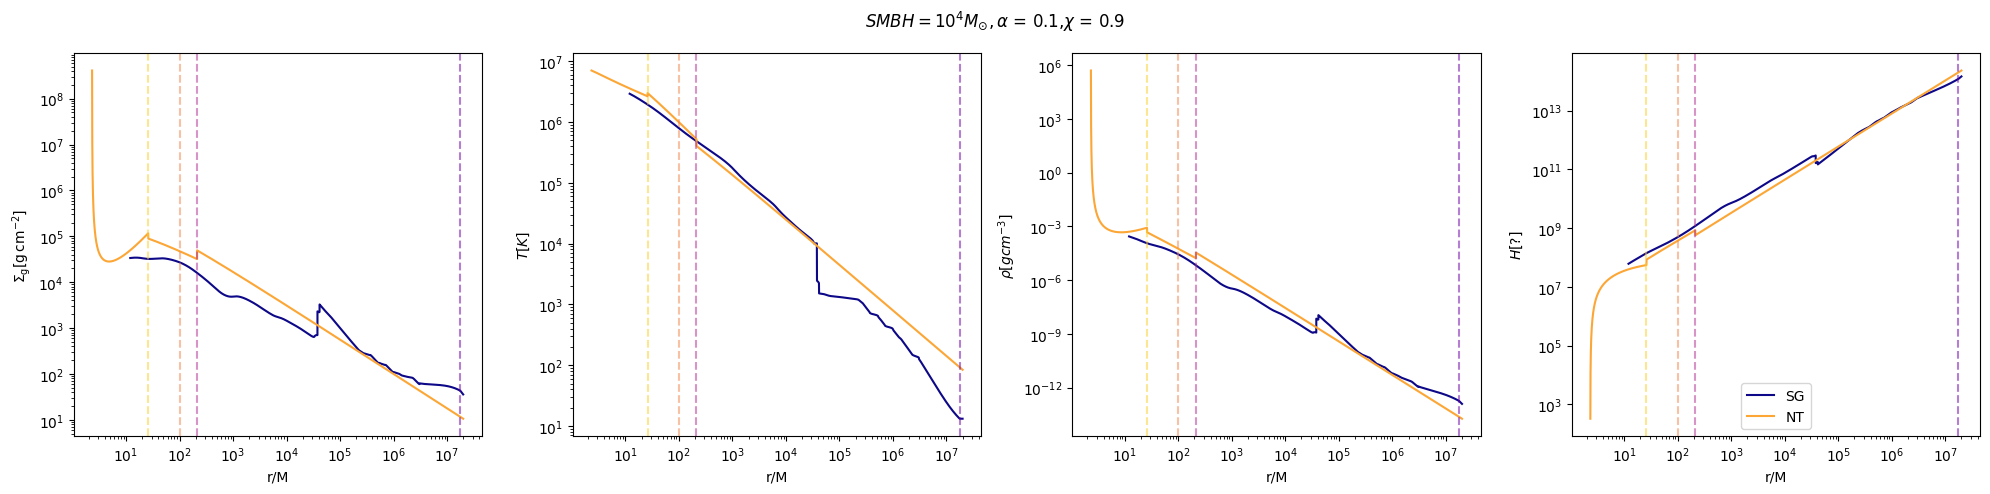

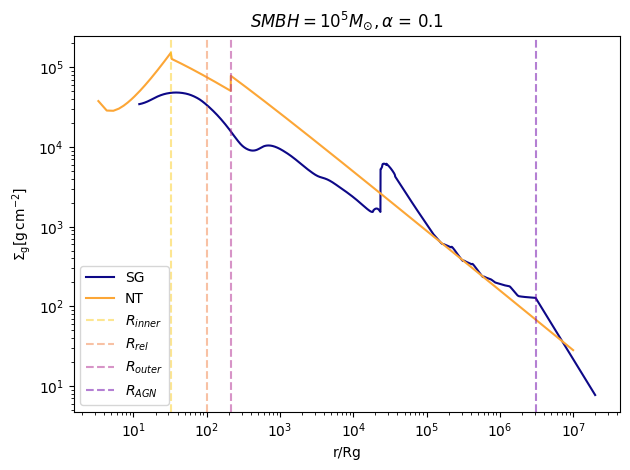

In [18]:
colour='plasma'
cmap = plt.colormaps[colour]

plt.plot(disk.R/R_G, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
plt.ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')
plt.xlabel("r/Rg")

plt.xscale('log')
plt.yscale('log')

plt.plot(Rs, sigmas, '-', color=cmap(0.8), label = r"NT")
# plt.plot(Rs_mid, sigmas_mid, '-', color=cmap(0.8), label = r"NT, Mid")
# plt.plot(Rs_outer, sigmas_outer, '-', color=cmap(0.6), label = r"NT, Outer")

plt.axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")


plt.legend()

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')

plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_SD_profiles_logMBH{MBH_power}_alpha{alpha}_3.pdf')
plt.show()

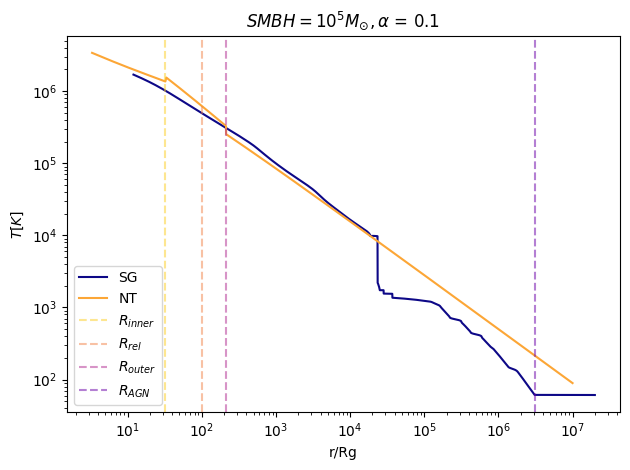

In [19]:

plt.plot(disk.R/R_G, disk.T, color=cmap(0.0), label = r"SG")
plt.ylabel(r'$T [K] $')
plt.xlabel("r/Rg")

plt.xscale('log')
plt.yscale('log')

plt.plot(Rs, Ts, '-', color=cmap(0.8), label = r"NT")
# plt.plot(Rs_mid, Ts_mid, '-', color=cmap(0.8), label = r"NT, Mid")
# plt.plot(Rs_outer, Ts_outer, '-', color=cmap(0.6), label = r"NT, Outer")

plt.axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')
plt.legend()
plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_T_profiles_logMBH{MBH_power}_alpha{alpha}_2.pdf')
plt.show()

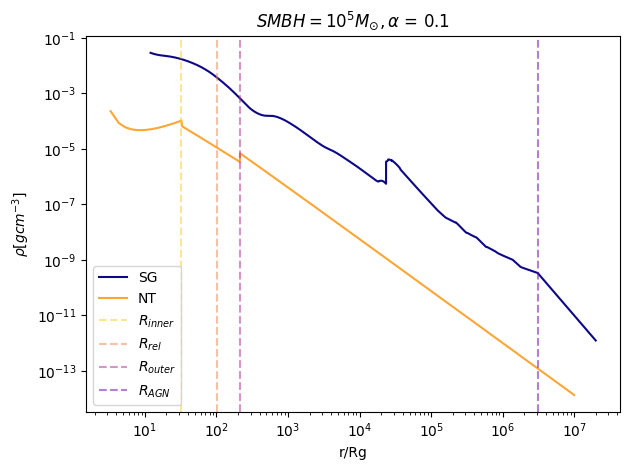

In [20]:

plt.plot(disk.R/R_G, disk.rho, color=cmap(0.0), label = r"SG")
plt.ylabel(r'$\rho [gcm^{-3}] $')
plt.xlabel("r/Rg")

plt.xscale('log')
plt.yscale('log')

plt.plot(Rs, rho0s, '-', color=cmap(0.8), label = r"NT")
# plt.plot(Rs_mid, Ts_mid, '-', color=cmap(0.8), label = r"NT, Mid")
# plt.plot(Rs_outer, Ts_outer, '-', color=cmap(0.6), label = r"NT, Outer")

plt.axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')
plt.legend()
plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_rho_profiles_logMBH{MBH_power}_alpha{alpha}_2.pdf')
plt.show()

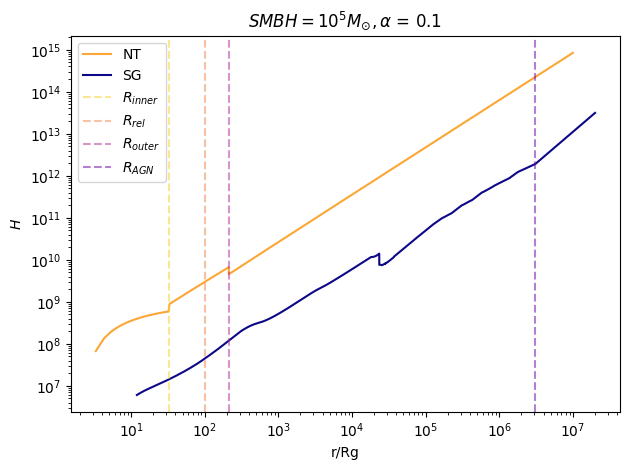

In [21]:

plt.ylabel(r'$H$')
plt.xlabel("r/Rg")

plt.xscale('log')
plt.yscale('log')

plt.plot(Rs, Hs, '-', color=cmap(0.8), label = r"NT")

plt.plot(disk.R/R_G, disk.h, '-', color=cmap(0.0), label = r"SG")

plt.axvline(x=R_im, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{inner}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=R_mo, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')
plt.legend()
plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_H_profiles_logMBH{MBH_power}_alpha{alpha}.pdf')
plt.show()

In [18]:
disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le= le, eps=eps)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 1.298344e+00 MSun/yr
le = 0.5
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=3408 (R=7.92e+02 Rs)
Beginning star formation at index 3408
Mdisk = 335459537.4383986 Msun
Mdisk/Mbh = 3.354595374383986


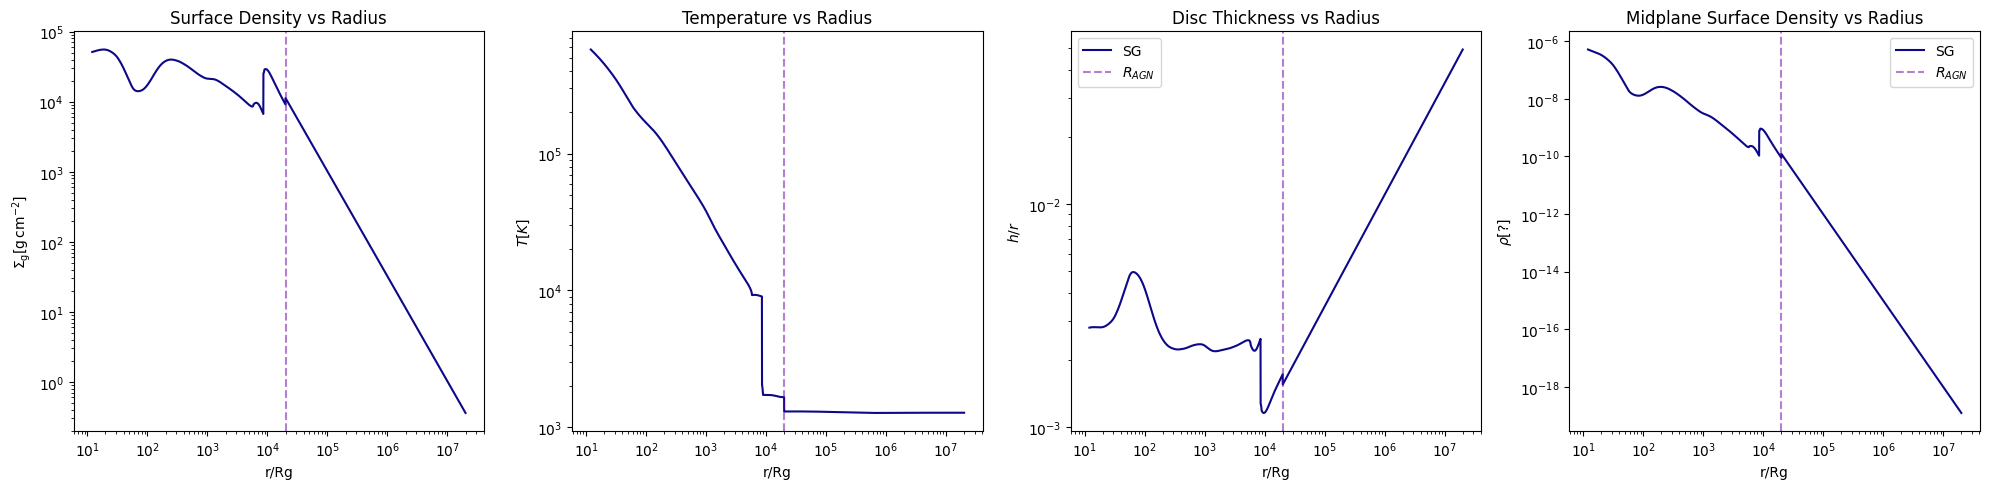

In [25]:
colour='plasma'
cmap = plt.colormaps[colour]

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=100)

i=0
axs[i].plot(disk.R/R_G, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(5, 1e6)
# axs[i].set_ylim(1, 1e7)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Surface Density vs Radius')

i=1
axs[i].plot(disk.R/R_G, disk.T, color=cmap(0.0), label = r"SG")
axs[i].set_ylabel(r'$T [K] $')
axs[i].set_xlabel("r/Rg")

axs[i].set_xscale('log')
axs[i].set_yscale('log')

# axs[i].set_xlim(5, 1e7)
# axs[i].set_ylim(1e1, 3e7)
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Temperature vs Radius')

i=2

axs[i].plot(disk.R/R_G, disk.h/disk.R, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$h/r$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(1, 1e7)
# axs[i].set_ylim(1, 1e7)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Disc Thickness vs Radius')
axs[i].legend()

i=3

axs[i].plot(disk.R/R_G, disk.rho/1e3, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$\rho [?]$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(1, 1e7)
# axs[i].set_ylim(1, 1e7)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Midplane Surface Density vs Radius')
axs[i].legend()


plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/SG_profiles_logMBH{MBH_power}_alpha{alpha}_3.pdf')
plt.show()